# Twitter Tourism in Finland

This notebook takes you through preprocessing the entire dataset and conducting the comparison analysis.

In [1]:
# Import modules
import glob
import os
import random 
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from pyproj import CRS
from datetime import datetime, timedelta
from twitter_visitor_funcitons import dissolveToRegions, mergeTweetsWithMunicipality, foreignerOrFinn

If the preprocessing already has been done, you can [jump over preprocessing](#Finnish-versus-foreign-per-municipality)

In [2]:
# This cell can be skipped if using 'points_from2017.gpkg'
# Loading point data from 2014 ->
point_fp = 'Points-twitter_cb_history_all_in_Fin_since2014.gpkg'
point_dataset = gpd.read_file(point_fp)
point_dataset['created_at'] = pd.to_datetime(point_dataset['created_at'])

point_dataset.head()


,coordinates,created_at,id,user_id,geometry
0,"(60.16866931, 24.94708769)",2015-12-10 16:34:33,674990598147850240,784040,POINT (24.94709 60.16867)
1,"(60.19039154, 24.90669732)",2016-05-31 07:03:51,737540074036830209,947851,POINT (24.90670 60.19039)
2,"(60.16470835, 24.93648848)",2013-05-10 07:10:07,332754404748967936,2079901,POINT (24.93649 60.16471)
3,"(60.1628, 24.9226)",2017-09-18 19:51:39,909867533829918720,2079901,POINT (24.92260 60.16280)
4,"(60.3177101, 24.96631918)",2018-07-04 21:08:30,1014616969746763781,3876361,POINT (24.96632 60.31771)


In [3]:
lines_fp = 'Twitter_histories_all_movements_in_Fin_since_2014.gpkg'
lines_data = gpd.read_file(lines_fp)
#lines_data['created_at'] = pd.to_datetime(lines_data['created_at'])

In [4]:
# This cell can be skipped if using 'points_from2017.gpkg'
# Subsetting data to start from October 2017
subset = point_dataset.loc[point_dataset['created_at'] >= "2017-10-01 00:00:00"]

# Writing subset to file
subset.to_file('points_from2017.gpkg', driver='GPKG')

In [5]:
# Loading data from 2017 ->
subset = gpd.read_file('points_from2017.gpkg')

In [6]:
print(f'Length of subset: {len(subset)}')
print(f'CRS of subset: {subset.crs}')

Length of subset: 193443
CRS of subset: epsg:4326


### Merging

In [7]:
# Reading line subset to gpd
all_hist_subset = gpd.read_file('Lines_from2017.gpgk')
# Loading total line dataset
all_history_data = "Twitter_histories_all_movements_in_Fin_since_2014.gpkg"
# Reading all history to gpd
all_hist = gpd.read_file(all_history_data)

In [8]:
# Read Finnish users to dataframe
finnish_users = pd.read_excel('Finnish_twitter_users_municipalities_by_uweeks_per_user.xlsx')
finnish_users['user_id'] = finnish_users['user_id'].astype(int)
finnish_users.head()

,user_id,home_municipality,Mun1,Mun2,Mun1_ID,Mun2_ID
0,4270,Helsinki,Helsinki,NaN,91,NaN
1,4587,Helsinki,Helsinki,NaN,91,NaN
2,5786,Kiuruvesi or Oulu,Kiuruvesi,Oulu,263,564.0
3,7632,Turku or Helsinki,Turku,Helsinki,853,91.0
4,10566,Helsinki,Helsinki,NaN,91,NaN


In [9]:
# Read Estonian users
estonians = gpd.read_file('estonians_all_years.shp')
estonians = estonians[['user_id','homeLoc']]
print(len(estonians))
estonians = estonians.drop_duplicates()
print(len(estonians))
estonians.head()

4289
380


,user_id,homeLoc
0,273304318,Estonia
3,29011483,Estonia
4,739011556059566080,Estonia
6,741059018010025985,Estonia
12,2902069136,Estonia


In [10]:
# Converting user_id to int
all_hist['user_id'] = all_hist['user_id'].astype(int)
estonians['user_id'] = estonians['user_id'].astype(int)
subset['user_id'] = subset['user_id'].astype(int)

# Subsetting all_hist to only user_id and home location
all_hist = all_hist[['user_id','homeLoc']]

# Mapping homeloc by user_id from all history
subset['homeLoc'] = subset['user_id'].map(all_hist.set_index('user_id')['homeLoc'].to_dict())
# Explicitly assigning Estonian users
subset['homeLoc'][subset['user_id'].isin(estonians['user_id'])] = 'Estonia'
# Mapping homeloc by user_id from finnish_users
subset['home_municipality'] = subset['user_id'].map(finnish_users.set_index('user_id')['home_municipality'].to_dict())

# Looping and setting location to Finland if they have a home municipality
for i, row in subset.iterrows():
    if row['home_municipality'] != 'nan':
        row['homeLoc'] = 'Finland'

print(subset.head())


/home/haavard/anaconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


                  coordinates           created_at                   id  \
0   (60.3177101, 24.96631918)  2018-07-04T21:08:30  1014616969746763781   
1  (60.17451971, 24.93688345)  2018-07-05T05:24:35  1014741813280702464   
2          (60.1708, 24.9375)  2018-07-05T06:17:52  1014755221073903616   
3      (60.16944444, 24.9525)  2018-07-05T07:06:07  1014767363747663873   
4  (60.16551516, 24.96500089)  2018-07-05T07:29:09  1014773160019931137   

   user_id                   geometry homeLoc home_municipality  
0  3876361  POINT (24.96632 60.31771)     NaN               NaN  
1  3876361  POINT (24.93688 60.17452)     NaN               NaN  
2  3876361  POINT (24.93750 60.17080)     NaN               NaN  
3  3876361  POINT (24.95250 60.16944)     NaN               NaN  
4  3876361  POINT (24.96500 60.16552)     NaN               NaN  


### Assigning random home municipality for users with two

In [11]:
# Skip this cell if you have 'tweetsWithLocale.gpkg'
import random 
subset['home_municipality'] = subset['home_municipality'].astype(str)
subset['home_municipality'].unique()
subset.groupby('home_municipality').home_municipality.count()

def trySplitAndReplace(string):
    #print(string)
    try:
        oldString = string.split(' or ')
        newString = oldString[random.randint(0,1)]
        return newString
    except:
        return string
subset['home_municipality'] = subset.apply(lambda row: trySplitAndReplace(row['home_municipality']), axis=1)
print(subset['home_municipality'].unique())



['nan' 'Tampere' 'Kirkkonummi' 'Helsinki' 'Kuopio' 'Espoo' 'Nokia'
 'HyvinkÃ¤Ã¤' 'Lahti' 'JyvÃ¤skylÃ¤' 'SeinÃ¤joki' 'RiihimÃ¤ki' 'Vaasa'
 'HÃ¤meenlinna' 'Laukaa' 'Lapinlahti' 'Turku' 'Porvoo' 'Vihti'
 'KÃ¤rsÃ¤mÃ¤ki' 'HeinÃ¤vesi' 'Pori' 'Kauniainen' 'JÃ¤rvenpÃ¤Ã¤' 'Vantaa'
 'Hammarland' 'Rauma' 'PieksÃ¤mÃ¤ki' 'Raasepori' 'Kauhajoki' 'Mikkeli'
 'Kaarina' 'Kokkola' 'Raahe' 'Koski Tl' 'KihniÃ¤' 'Oulu' 'Salo'
 'Rovaniemi' 'Sipoo' 'Puolanka' 'Oulainen' 'Sastamala' 'Kotka' 'Sotkamo'
 'Kouvola' 'Pietarsaari' 'Heinola' 'KemiÃ¤nsaari' 'Lappeenranta'
 'Harjavalta' 'MÃ¤nttÃ¤-Vilppula' 'Masku' 'Maarianhamina' 'Tuusniemi'
 'Nakkila' 'Lohja' 'Lieto' 'NurmijÃ¤rvi' 'Juuka' 'Kuusamo' 'Outokumpu'
 'Ã¤htÃ¤ri' 'Raisio' 'Ylivieska' 'PedersÃ¤ren kunta' 'Kempele' 'Joensuu'
 'MÃ¤ntsÃ¤lÃ¤' 'Parainen' 'Tuusula' 'Muhos' 'Inari' 'Punkalaidun'
 'YlÃ¤jÃ¤rvi' 'PÃ¤lkÃ¤ne' 'Alavus' 'Imatra' 'LappajÃ¤rvi' 'Naantali'
 'Uurainen' 'Kalajoki' 'Savonlinna' 'Merikarvia' 'Liminka' 'Hollola'
 'Muurame' 'Lumijoki' 'Liperi' 'Kera

In [12]:
# Skip this cell if you have 'tweetsWithLocale.gpkg'
import random 
subset['homeLoc'] = subset['homeLoc'].astype(str)
subset['homeLoc'].unique()
subset.groupby('homeLoc').homeLoc.count()

def trySplitAndReplace(string):
    #print(string)
    try:
        oldString = string.split(' or ')
        newString = oldString[random.randint(0,1)]
        return newString
    except:
        return string
subset['homeLoc'] = subset.apply(lambda row: trySplitAndReplace(row['homeLoc']), axis=1)
print(subset['homeLoc'].unique())

['nan' 'United Kingdom' 'Finland' 'Estonia' 'Italy' 'Japan' 'Latvia'
 'Netherlands' 'United States' 'Russia' 'Sweden' 'Norway' 'Brazil'
 'Australia' 'Spain' 'Malaysia' 'Germany' 'South Africa' 'France'
 'Slovenia' 'Mexico' 'Thailand' 'Denmark' 'Philippines' 'Singapore'
 'Turkey' 'Switzerland' 'China' 'Taiwan' 'India' 'United Arab Emirates'
 'Uzbekistan' 'Ukraine' 'Kenya' 'Hungary' 'Belgium' 'Egypt' 'Portugal'
 'Austria' 'Iceland' 'Chile' 'Canada' 'Yemen' 'Ireland' 'Czech Republic'
 'Indonesia' 'Hong Kong' 'Lithuania' 'Swaziland' 'El Salvador' 'Serbia'
 'Greece' 'Israel' 'Colombia' 'Argentina' 'Poland' 'Korea, Republic of'
 'Kuwait' 'Nigeria' 'Bulgaria' 'Iraq' 'Qatar' 'Belarus'
 'Dominican Republic' 'Sri Lanka' 'Bahrain' 'Saudi Arabia' 'Kosovo'
 'Morocco' 'Uruguay' 'Guatemala' 'Cyprus' 'Romania' 'Pakistan'
 'Costa Rica' 'Palestine' 'Tanzania' 'Malta' 'Azerbaijan' 'Vietnam'
 'Armenia' 'Paraguay' 'New Zealand']


In [13]:
# Saving subset with origin country and home municipality
subset.head()
subset.to_file('tweetsWithLocale.gpkg', driver='GPKG')

In [14]:
# Read new subset
subset = gpd.read_file('tweetsWithLocale.gpkg')

# Finland map

In [15]:
# Load Finland municipality to gpd and copy crs
shapefile = "hallintorajat_10k/2018/SuomenKuntajako_2018_10k.shp"
finland = gpd.read_file(shapefile)
print(finland.crs)
old_crs = finland.crs

epsg:3067


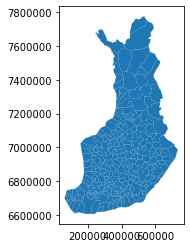

In [16]:
# Plot map to check
finland.plot()

# Joining data

In [17]:
# Align CRS
subset = subset.to_crs(finland.crs)
print(f'CRS the same: {subset.crs == finland.crs}')
# Merge by tweets in municipality
merged = gpd.sjoin(finland, subset, how='inner', op='contains')

CRS the same: True


In [18]:
merged.head()

,GML_ID,NATCODE,NAMEFIN,NAMESWE,geometry,index_right,coordinates,created_at,id,user_id,homeLoc,home_municipality
0,27666548,935,Virolahti,Virolahti,"POLYGON ((548651.109 6720005.165, 548389.385 6...",185129,"(60.60562436, 27.87113949)",2017-11-01T14:40:25,925734275625967616,1308322681,nan,nan
0,27666548,935,Virolahti,Virolahti,"POLYGON ((548651.109 6720005.165, 548389.385 6...",162500,"(60.60585919, 27.85134132)",2018-02-10T06:32:21,962212623419891712,305758649,Russia,nan
0,27666548,935,Virolahti,Virolahti,"POLYGON ((548651.109 6720005.165, 548389.385 6...",613,"(60.60650635, 27.85282831)",2019-01-06T09:33:18,1081846160124461056,320659418,nan,nan
0,27666548,935,Virolahti,Virolahti,"POLYGON ((548651.109 6720005.165, 548389.385 6...",612,"(60.60662842, 27.85417306)",2019-01-06T09:20:25,1081842917558358016,320659418,nan,nan
0,27666548,935,Virolahti,Virolahti,"POLYGON ((548651.109 6720005.165, 548389.385 6...",172820,"(60.60886395, 27.64318389)",2019-08-28T10:40:02,1166661712914911232,3291286474,nan,nan


In [19]:
# Group by name of municipality
grouped = merged.groupby('NAMEFIN')

## Total users by municipality

In [20]:
# Make a copy of Finland dataset
usersPerMun = finland.copy()
# Create number of users column
usersPerMun['numUsers'] = None

i = 0
for key, group in grouped:
    num = group['user_id'].nunique()
    usersPerMun.loc[usersPerMun['NAMEFIN']==key, ['numUsers']] = num
    i += 1
print(usersPerMun.head())

     GML_ID NATCODE      NAMEFIN     NAMESWE  \
0  27666548     935    Virolahti   Virolahti   
1  27677280     143    Ikaalinen      Ikalis   
2  27674158     261      Kittilä     Kittilä   
3  27666143     109  Hämeenlinna  Tavastehus   
4  27668817     290        Kuhmo       Kuhmo   

                                            geometry numUsers  
0  POLYGON ((548651.109 6720005.165, 548389.385 6...       40  
1  MULTIPOLYGON (((282711.987 6877281.390, 282689...       41  
2  POLYGON ((428510.971 7449194.171, 428355.473 7...      226  
3  POLYGON ((351222.859 6782799.340, 351225.300 6...      290  
4  POLYGON ((643121.301 7165811.375, 643536.981 7...       29  


In [21]:
print(usersPerMun.tail(14))
print(type(usersPerMun['GML_ID'][2]))

       GML_ID NATCODE    NAMEFIN    NAMESWE  \
297  27674173     047  Enontekiö  Enontekis   
298  27665173     790  Sastamala  Sastamala   
299  27673284     625   Pyhäjoki   Pyhäjoki   
300  27667214     260      Kitee      Kitee   
301  27663484     738      Sauvo       Sagu   
302  27670889     217     Kannus     Kannus   
303  27668997     297     Kuopio     Kuopio   
304  27674603     240       Kemi       Kemi   
305  27663808     019       Aura       Aura   
306  27669727     992  Äänekoski  Äänekoski   
307  27664643     753      Sipoo      Sibbo   
308  27668285     759      Soini      Soini   
309  27671354     436   Lumijoki   Lumijoki   
310  27665666     182      Jämsä      Jämsä   

                                              geometry numUsers  
297  POLYGON ((345880.518 7564695.656, 345855.897 7...       72  
298  MULTIPOLYGON (((297708.422 6828597.687, 297680...       77  
299  MULTIPOLYGON (((386693.361 7141215.377, 386462...        9  
300  POLYGON ((635242.406 6845

In [22]:
usersPerMun = usersPerMun.to_crs(old_crs)
usersPerMun['numUsers'] = usersPerMun['numUsers'].astype(int)

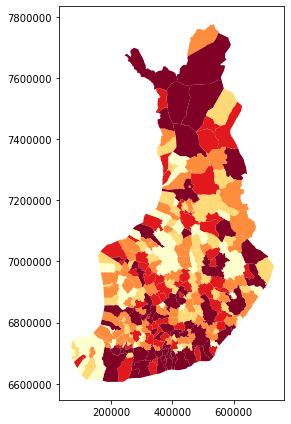

In [23]:

# Control figure size in here
fig, ax = plt.subplots(figsize=(24,6))

# Visualize the travel times into 9 classes using "Quantiles" classification scheme
usersPerMun.plot(ax=ax, column="numUsers", linewidth=0.03, cmap="YlOrRd", scheme="quantiles", k=5, alpha=1)

# Remove the empty white-space around the axes
plt.tight_layout()

# Save the figure as png file with resolution of 300 dpi
usersPerMun.to_file('UsersPerMunicipality_2017-2019.gpkg', driver='GPKG')
#subset.to_file('points_from2017.gpkg', driver='GPKG')
outfp = "static_map.png"
plt.savefig(outfp, dpi=300)

# Finnish versus foreign per municipality

## Merging twitterLocations with municipalities

In [24]:
municipalities = "hallintorajat_10k/2018/SuomenKuntajako_2018_10k.shp"
tweetsWithLocale = 'tweetsWithLocale.gpkg'
regions_fp = 'hallintorajat_10k/2018/SuomenMaakuntajako_2018_10k.shp'

In [25]:
merged = mergeTweetsWithMunicipality(tweetsWithLocale, municipalities)

Finns tweeting in home municipality dropped: 81930
New number of tweets in dataset:111512


In [26]:
merged.tail()

,GML_ID,NATCODE,NAMEFIN,NAMESWE,geometry,index_right,coordinates,created_at,id,user_id,homeLoc,home_municipality,date,YR,MN,YearMonth
310,27665666,182,Jämsä,Jämsä,"POLYGON ((24.73091 62.02319, 24.73321 62.02375...",129209,"(62.00335, 24.71748)",2018-02-14T08:54:02,963697830442536961,3063829911,Finland,Helsinki,2018-02-14 08:54:02,2018,2,201802
310,27665666,182,Jämsä,Jämsä,"POLYGON ((24.73091 62.02319, 24.73321 62.02375...",129205,"(62.00335, 24.71748)",2018-02-14T12:24:01,963750677834092545,3063829911,Finland,Helsinki,2018-02-14 12:24:01,2018,2,201802
310,27665666,182,Jämsä,Jämsä,"POLYGON ((24.73091 62.02319, 24.73321 62.02375...",127437,"(62.00426641, 24.71563962)",2018-07-08T10:21:04,1015903586570694656,3063829911,Finland,Helsinki,2018-07-08 10:21:04,2018,7,201807
310,27665666,182,Jämsä,Jämsä,"POLYGON ((24.73091 62.02319, 24.73321 62.02375...",191281,"(61.89366719, 24.64672573)",2019-05-26T17:35:02,1132701692934393856,2831214083,nan,nan,2019-05-26 17:35:02,2019,5,201905
310,27665666,182,Jämsä,Jämsä,"POLYGON ((24.73091 62.02319, 24.73321 62.02375...",89926,"(61.9875298, 24.6431904)",2019-06-25T17:12:04,1143567548442714112,1159556148,Finland,Espoo,2019-06-25 17:12:04,2019,6,201906


### Users per country

In [27]:
tweets = gpd.read_file(tweetsWithLocale)
peoplePerCountry =  tweets.groupby('homeLoc')['user_id'].nunique()

userCountries = peoplePerCountry.to_frame()
userCountries = userCountries.rename(columns={'user_id':'users_from_country'})
userCountries.to_csv('usersPerOrigin.csv')

## Split into seasons

In [28]:
# Selecting season by months
fall2017 = merged.loc[(merged['YearMonth'] >= 201710) & (merged['YearMonth'] <= 201711)]
winter2017_2018 = merged.loc[(merged['YearMonth'] >= 201712) & (merged['YearMonth'] <= 201802)]
spring2018 = merged.loc[(merged['YearMonth'] >= 201803) & (merged['YearMonth'] <= 201805)]
summer2018 = merged.loc[(merged['YearMonth'] >= 201806) & (merged['YearMonth'] <= 201808)]
fall2018 = merged.loc[(merged['YearMonth'] >= 201809) & (merged['YearMonth'] <= 201811)]
winter2018_2019  = merged.loc[(merged['YearMonth'] >= 201812) & (merged['YearMonth'] <= 201902)]
spring2019 = merged.loc[(merged['YearMonth'] >= 201903) & (merged['YearMonth'] <= 201905)]
summer2019 = merged.loc[(merged['YearMonth'] >= 201906) & (merged['YearMonth'] <= 201908)]
fall2019 = merged.loc[(merged['YearMonth'] >= 201909) & (merged['YearMonth'] <= 201911)]

In [29]:
# Drop duplicate users
fall2017 = fall2017.drop_duplicates('user_id')
winter2017_2018 = winter2017_2018.drop_duplicates('user_id')
spring2018 = spring2018.drop_duplicates('user_id')
summer2018 = summer2018.drop_duplicates('user_id')
fall2018 = fall2018.drop_duplicates('user_id')
winter2018_2019 = winter2018_2019.drop_duplicates('user_id')
spring2019 = spring2019.drop_duplicates('user_id')
summer2019 = summer2019.drop_duplicates('user_id')
fall2019 = fall2019.drop_duplicates('user_id')

### Writing season files

In [30]:
# Adding variable names to list
season_names = ['fall2017', 'winter2017_2018','spring2018','summer2018','fall2018','winter2018_2019', 'spring2019', 'summer2019','fall2019']
seasons = [fall2017, winter2017_2018, spring2018, summer2018, fall2018, winter2018_2019, spring2019, summer2019,fall2019]
i = 0
# Writing to files
for season in seasons:
    name = str(season_names[i])
    path = 'seasons/'+name+'.gpkg'
    season.to_file(path, driver='GPKG')
    print(f'Wrote {name} to file.')
    print(f'{i+1} out of {len(season_names)} written.')
    i += 1

Wrote fall2017 to file.
1 out of 9 written.
Wrote winter2017_2018 to file.
2 out of 9 written.
Wrote spring2018 to file.
3 out of 9 written.
Wrote summer2018 to file.
4 out of 9 written.
Wrote fall2018 to file.
5 out of 9 written.
Wrote winter2018_2019 to file.
6 out of 9 written.
Wrote spring2019 to file.
7 out of 9 written.
Wrote summer2019 to file.
8 out of 9 written.
Wrote fall2019 to file.
9 out of 9 written.


## Dissolve to Regions and foreignerOrFinn

In [31]:
regions_fp = 'hallintorajat_10k/2018/SuomenMaakuntajako_2018_10k.shp'
regions = gpd.read_file(regions_fp)
regions = regions.to_crs(merged.crs)

In [32]:
# Open each file in the 'seasons' directory
for file in os.listdir('seasons/'):
    # Only files that end with '.gpkg'
    if file.endswith('.gpkg'):
        full_path= os.path.join("seasons", file)
        # Read file to geoDataFrame
        df = gpd.read_file(full_path)
        # Make a copy of the regions dataset
        new_regions = regions.copy()
        # Add foreigners and visitor columns
        new_regions['finns_visiting'] = 0
        new_regions['foreigners'] = 0
        df = df.drop(['index_right'], axis=1)
        # Run dissolve dataframe to regions
        dissolved = dissolveToRegions(df, regions)
        print(f'Dissolved {full_path}')
        # Only select relevant columns
        dissolved = dissolved.drop(['index_right','GML_ID_right', 'NATCODE_right', 'NAMEFIN_right', 'NAMESWE_right','GML_ID_left', 'NATCODE_left', 'NAMESWE_left'], axis=1)
        dissolved = dissolved.rename(columns={'NAMEFIN_left': 'NAMEFIN'})
        # Run ForeignerOrFinn
        dissolved = foreignerOrFinn(dissolved,regions)
        # Group by regions
        grouped = dissolved.groupby('NAMEFIN')
        # For each region, calculate finns visiting and foreigners
        for key, group in grouped:
            # Sum up visitors
            finns = int(group['finns_visiting'].sum())
            foreign = int(group['foreigners'].sum())
            # Add visitor numbers to new regional dataset
            new_regions.loc[new_regions['NAMEFIN']==key, ['finns_visiting']] = finns
            new_regions.loc[new_regions['NAMEFIN']==key, ['foreigners']] = foreign
            
        name = file[:-5]
        output_path = 'regions_seasons/'+name+'_regional.gpkg'
        # Save new regional data sets for each seasons
        new_regions.to_file(output_path,driver='GPKG')
        print(f'{output_path} written to file.')

Dissolved seasons/spring2019.gpkg
regions_seasons/spring2019_regional.gpkg written to file.
Dissolved seasons/spring2018.gpkg
regions_seasons/spring2018_regional.gpkg written to file.
Dissolved seasons/fall2018.gpkg
regions_seasons/fall2018_regional.gpkg written to file.
Dissolved seasons/winter2017_2018.gpkg
regions_seasons/winter2017_2018_regional.gpkg written to file.
Dissolved seasons/summer2018.gpkg
regions_seasons/summer2018_regional.gpkg written to file.
Dissolved seasons/summer2019.gpkg
regions_seasons/summer2019_regional.gpkg written to file.
Dissolved seasons/fall2017.gpkg
regions_seasons/fall2017_regional.gpkg written to file.
Dissolved seasons/winter2018_2019.gpkg
regions_seasons/winter2018_2019_regional.gpkg written to file.
Dissolved seasons/fall2019.gpkg
regions_seasons/fall2019_regional.gpkg written to file.


# Plotting Regions/Seasons

In [33]:
regional_names = ['fall2017_regional', 'winter2017_2018_regional','spring2018_regional','summer2018_regional'\
                  ,'fall2018_regional','winter2018_2019_regional', 'spring2019_regional', 'summer2019_regional','fall2019_regional']
labels = ['Fall 2017', 'Winter 2017-2018','Spring 2018','Summer 2018','Fall 2018','Winter 2018-2019', 'Spring 2019', 'Summer 2019','Fall 2019']
official_finns = 'officialStats/finnishv3_s.shp'
official_foreigners = 'officialStats/foreignv3_s.shp'
finland_fp = "hallintorajat_10k/2018/SuomenMaakuntajako_2018_10k.shp"

## Twitter comparison

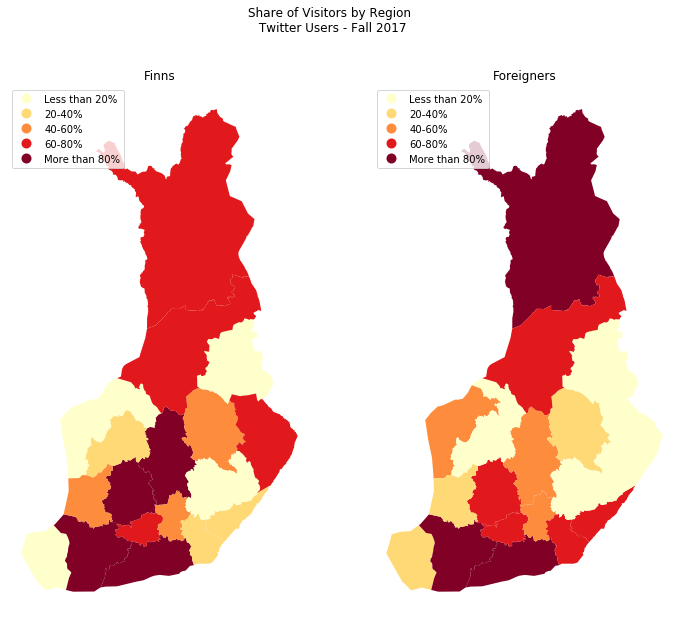

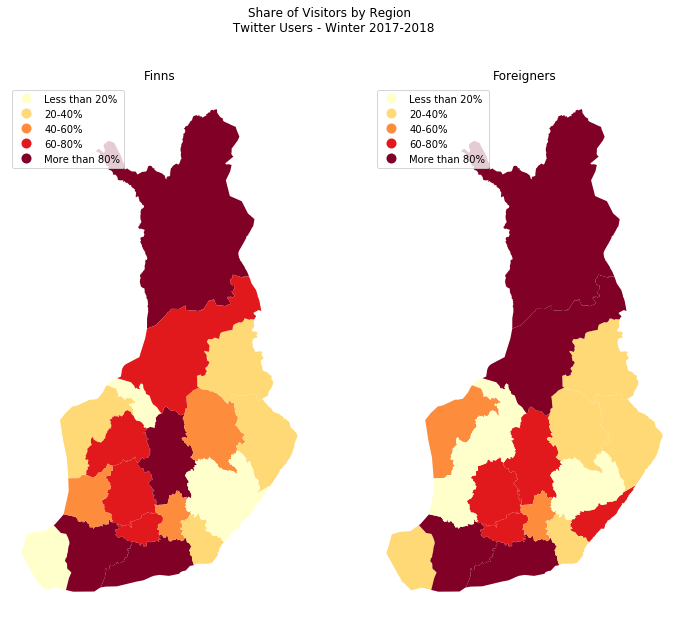

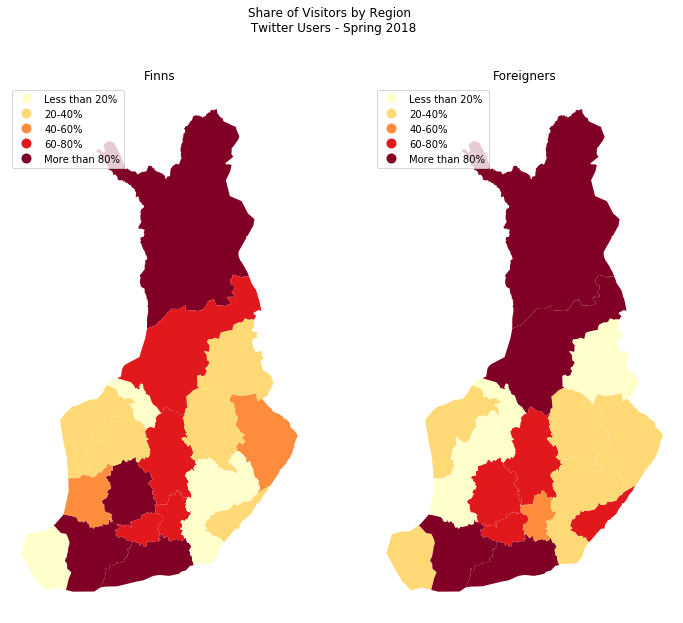

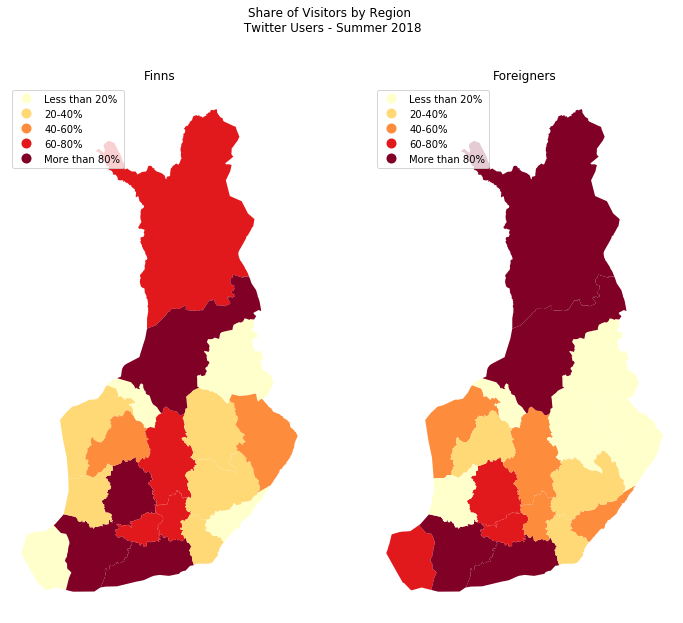

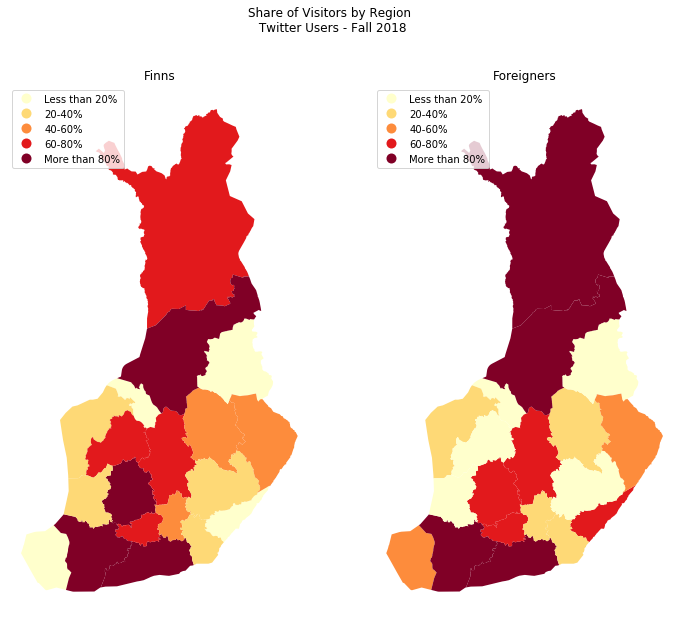

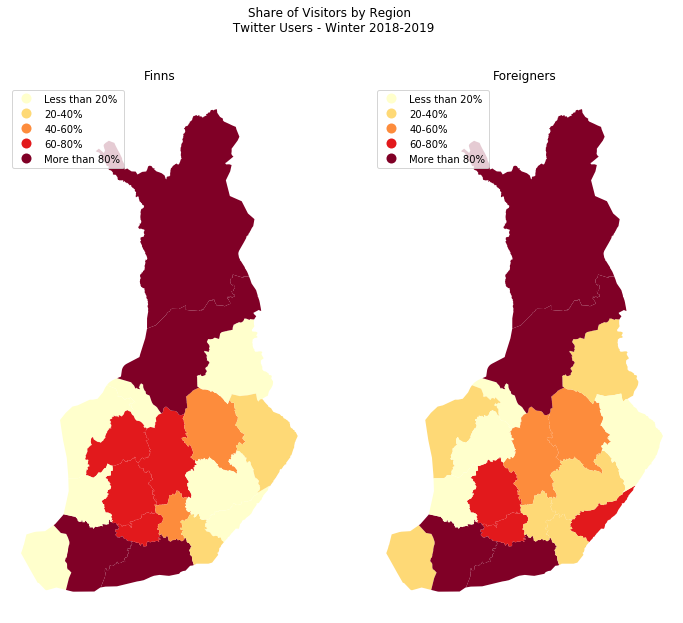

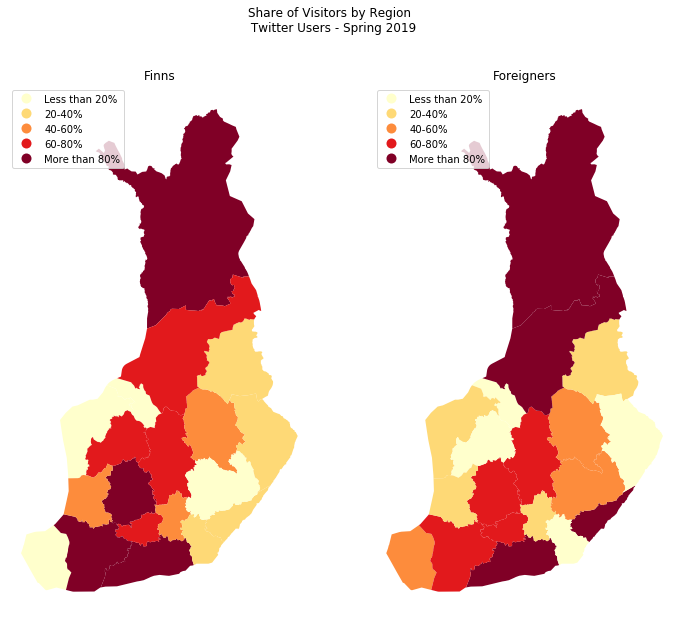

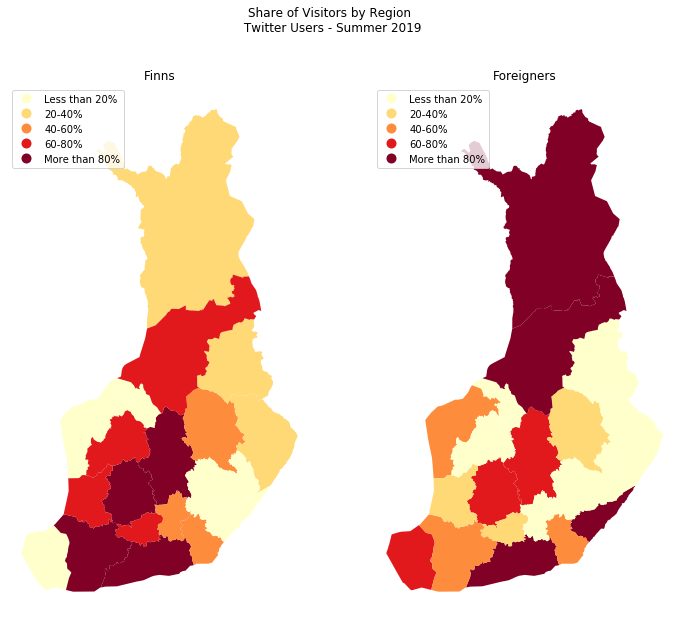

/home/haavard/anaconda3/envs/gis/lib/python3.7/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/home/haavard/anaconda3/envs/gis/lib/python3.7/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/home/haavard/anaconda3/envs/gis/lib/python3.7/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/home/haavard/anaconda3/envs/gis/lib/python3.7/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)


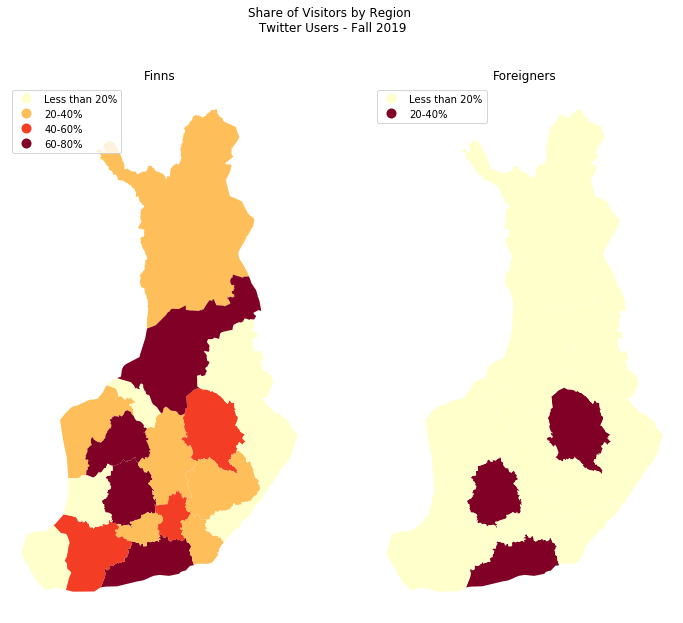

In [34]:
from twitter_visitor_funcitons import twitterComparisonFinnsForeigners

twitterComparisonFinnsForeigners(regional_names,labels)

## Offical vs Twitter - Finns

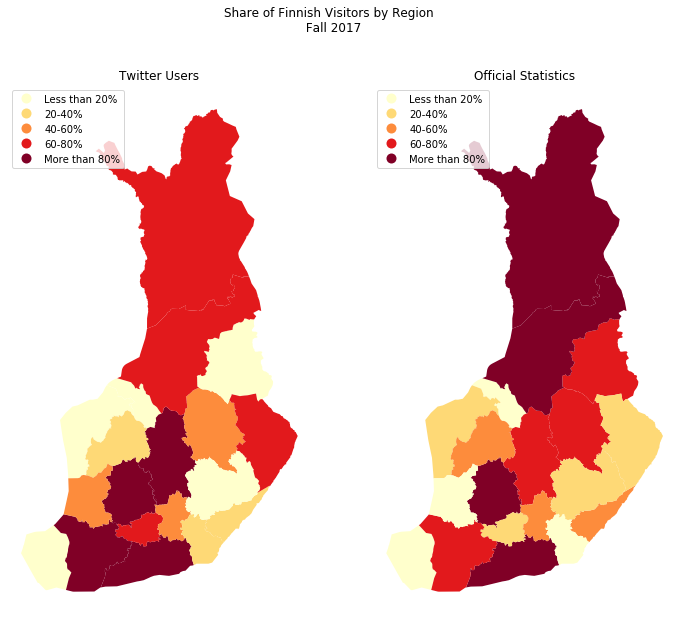

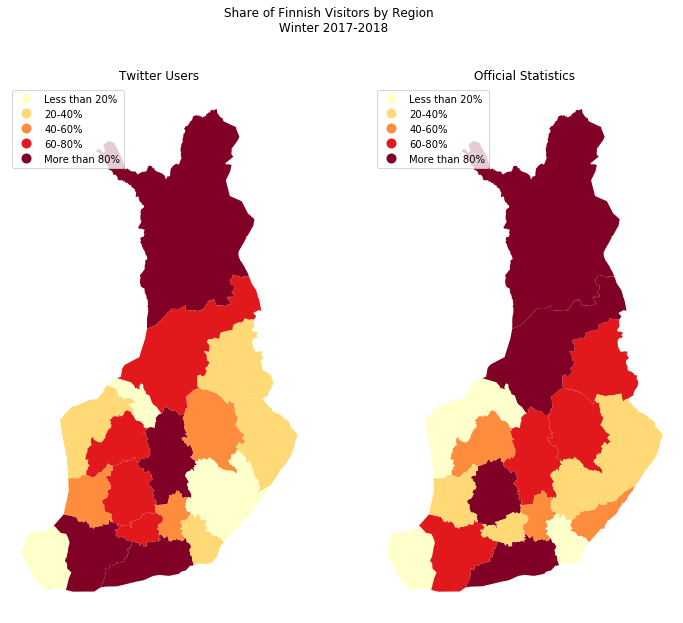

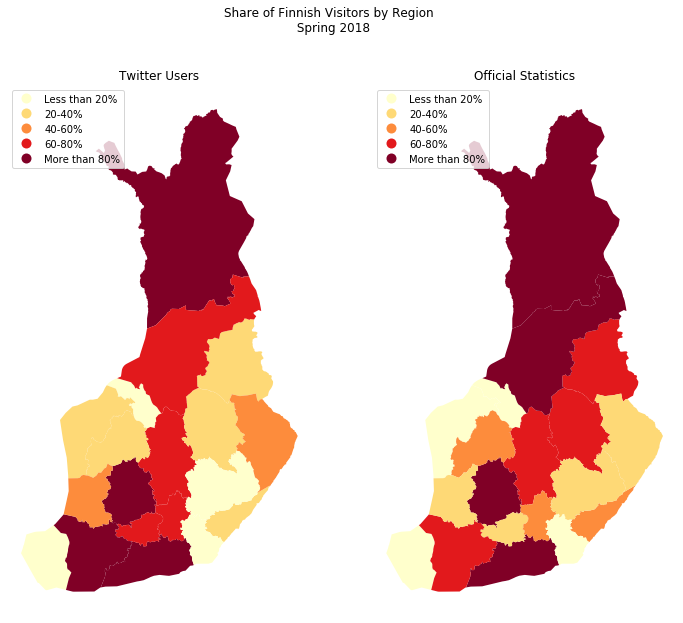

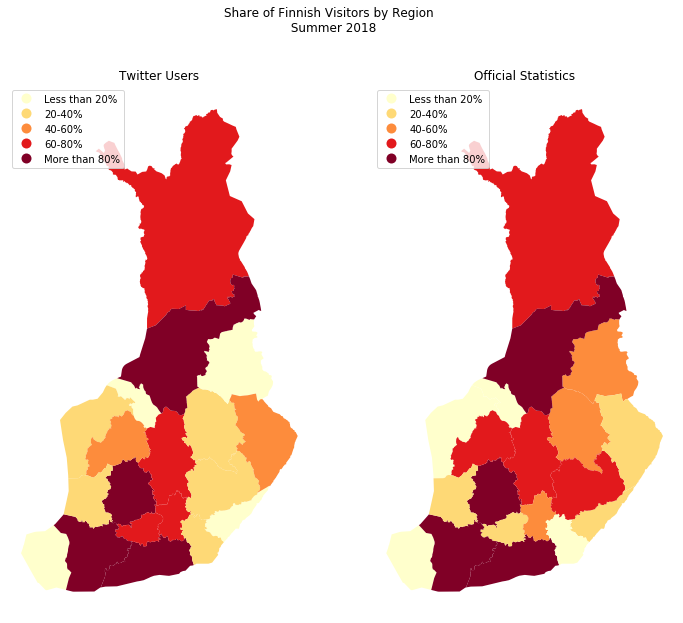

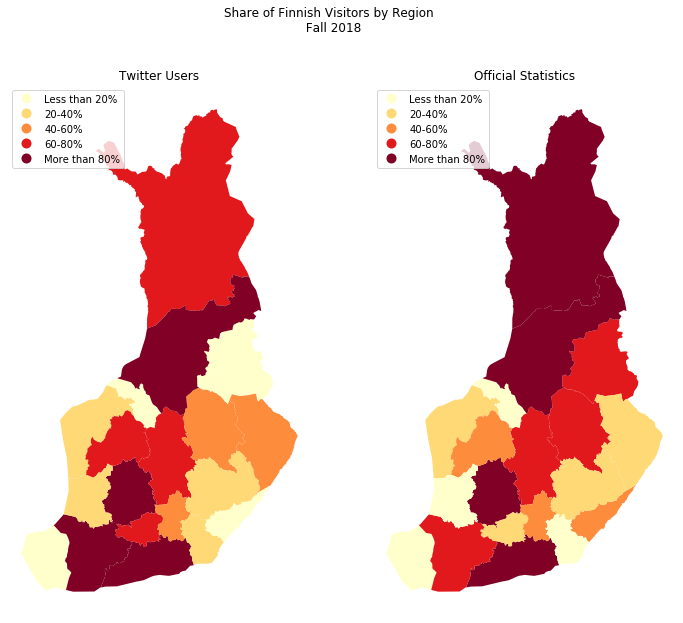

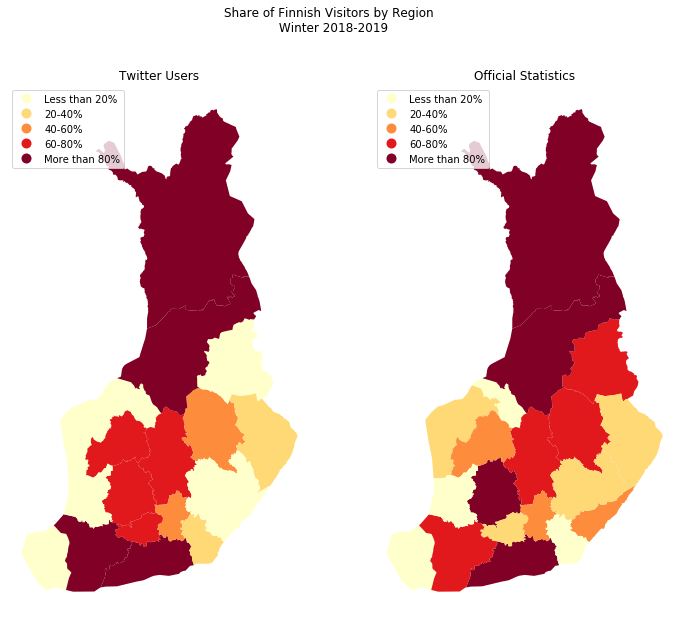

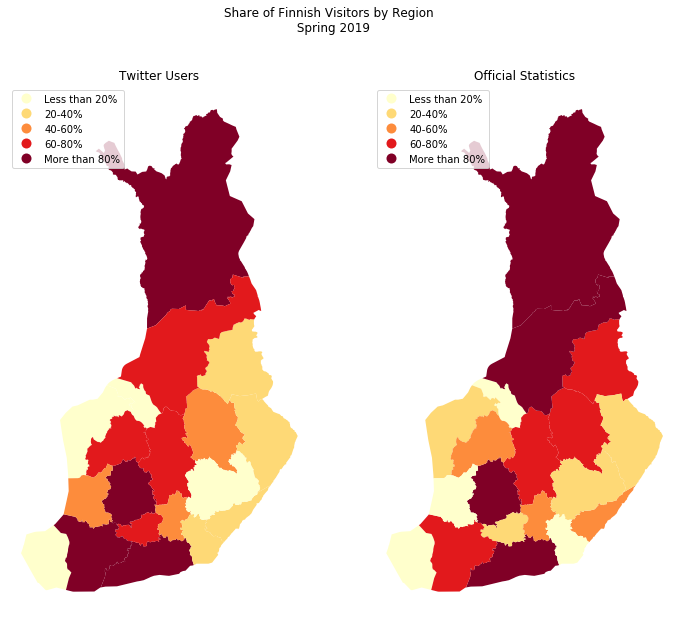

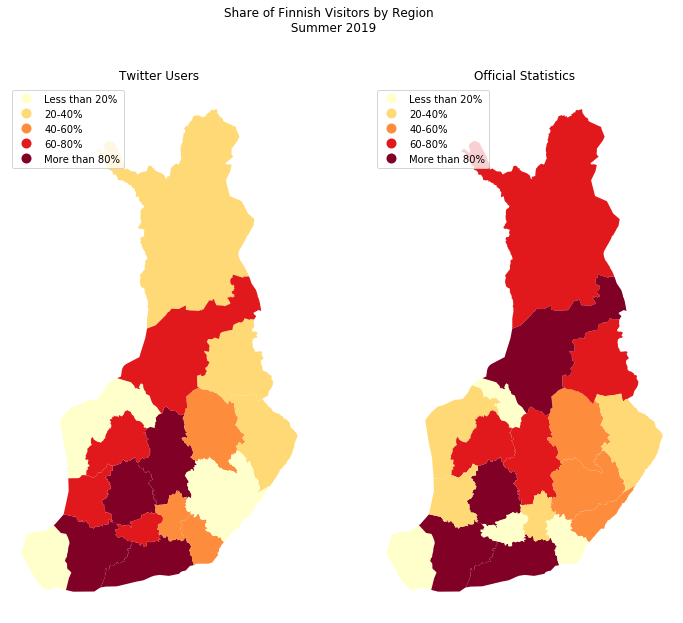

/home/haavard/anaconda3/envs/gis/lib/python3.7/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/home/haavard/anaconda3/envs/gis/lib/python3.7/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


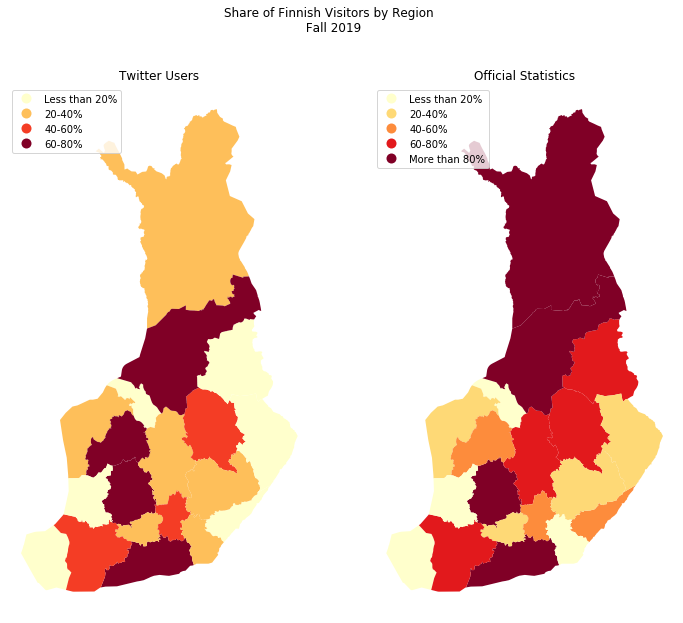

In [35]:
from twitter_visitor_funcitons import finnsTwitterOfficial

finnsTwitterOfficial(regional_names, official_finns, labels, finland_fp)

## Official vs Twitter - Foreigners

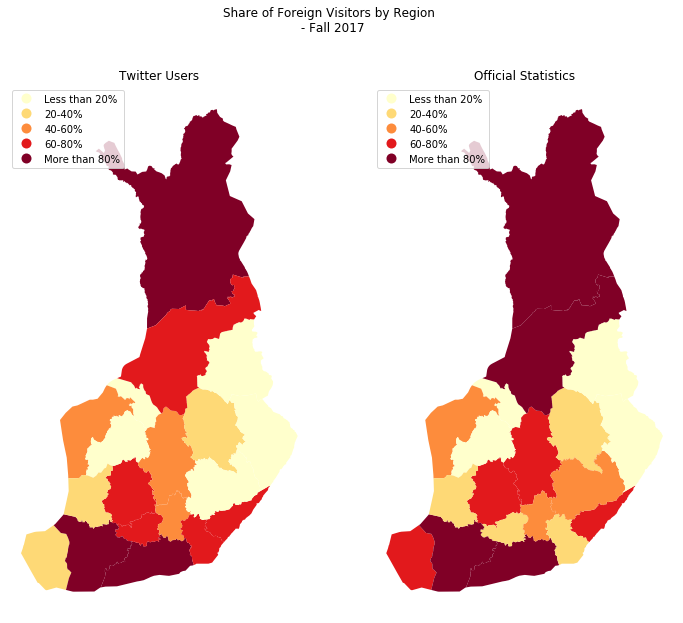

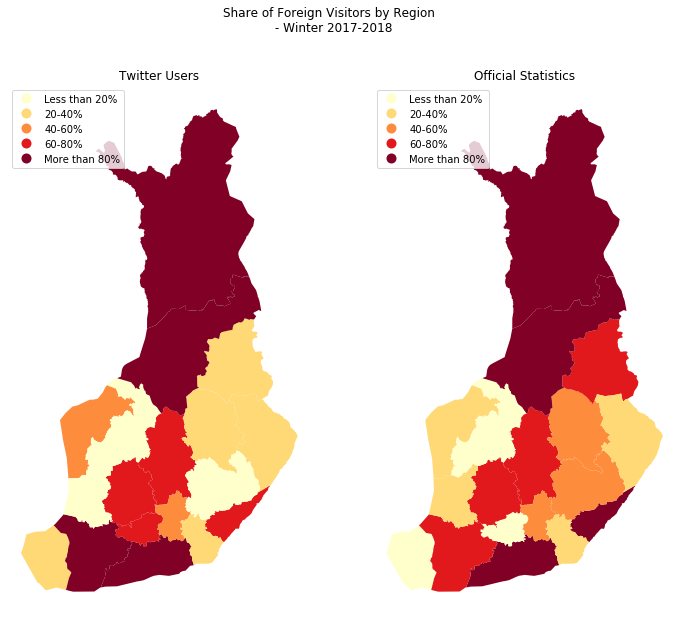

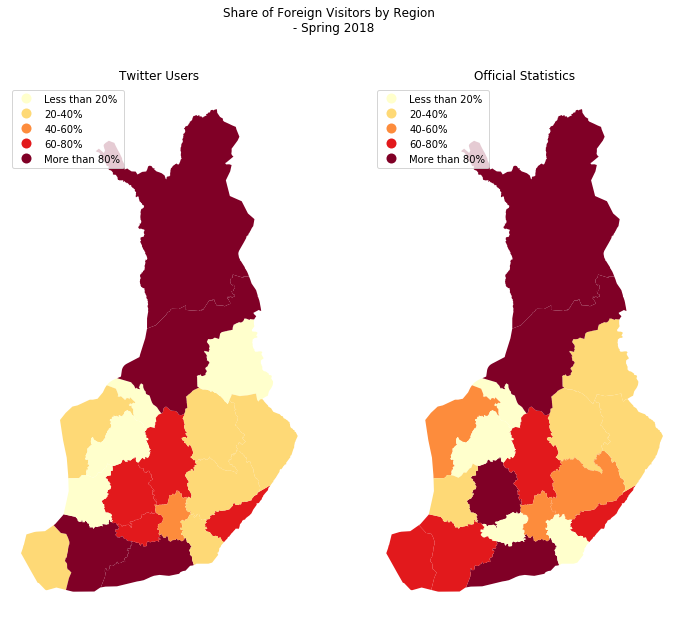

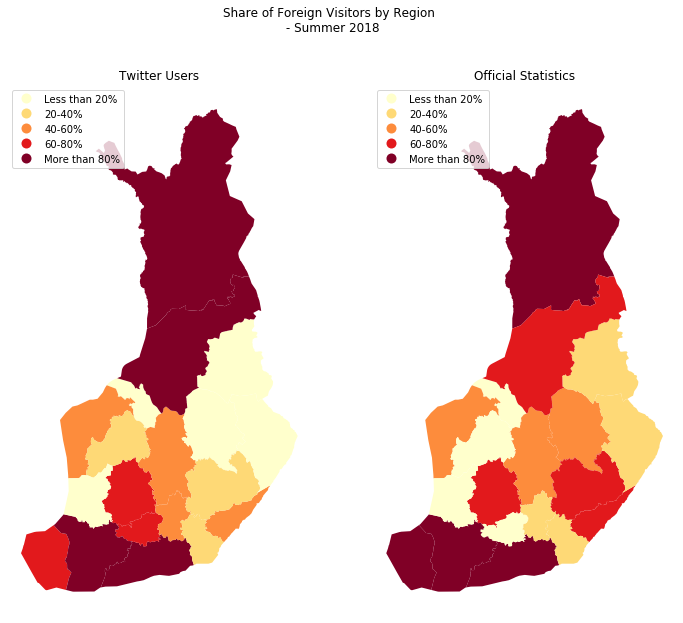

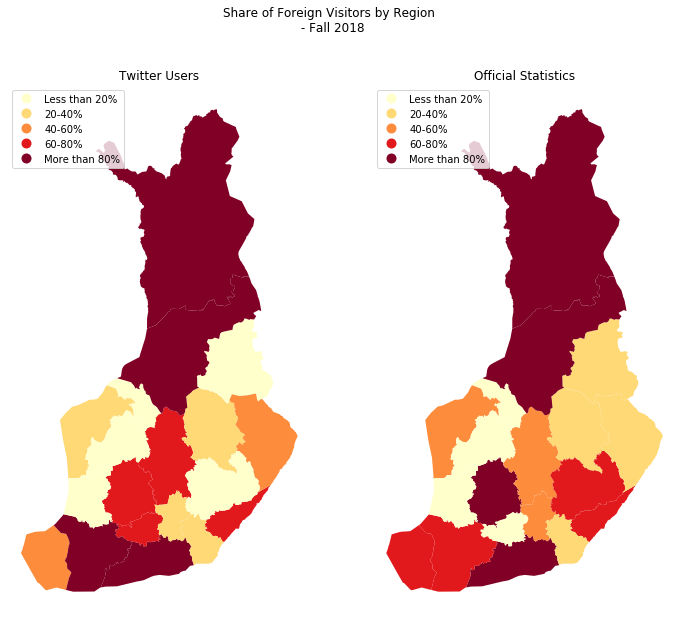

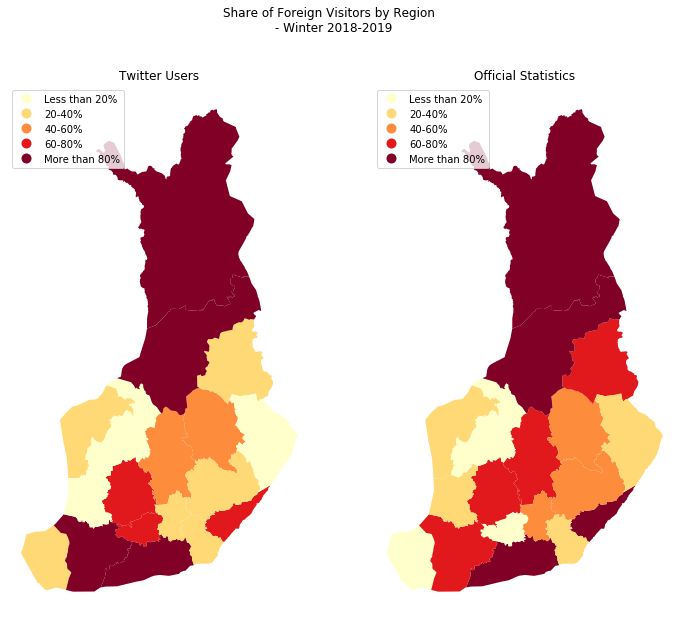

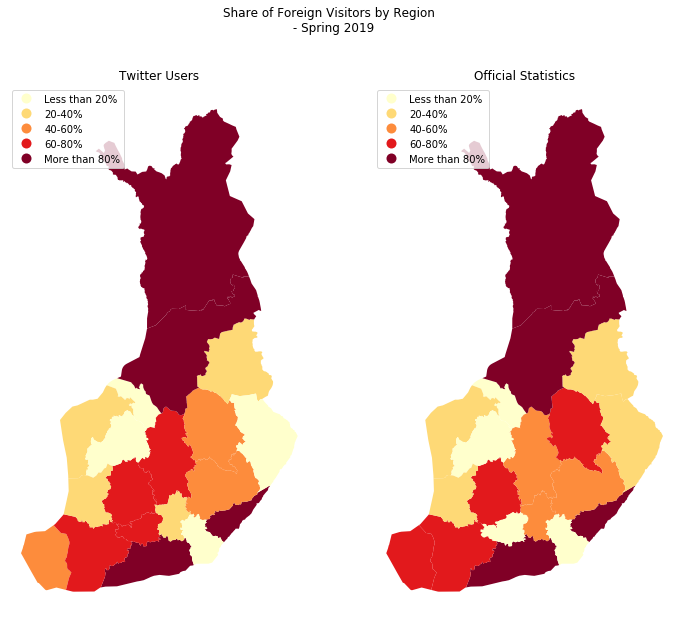

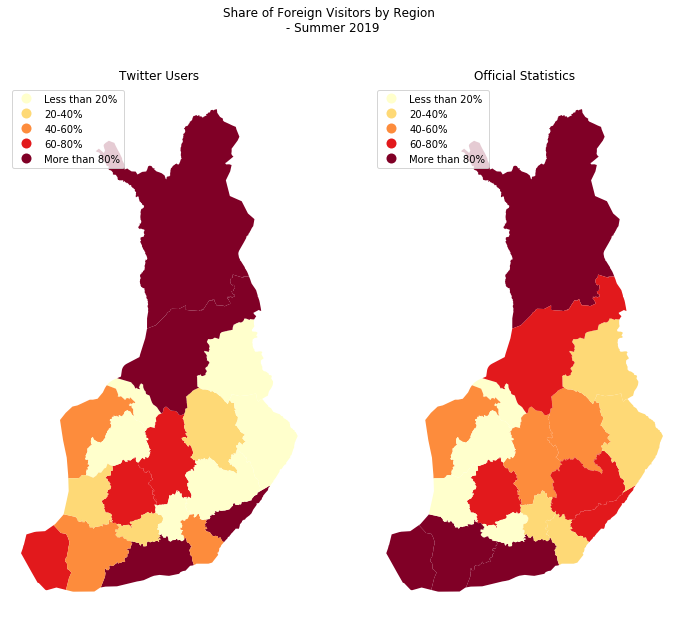

/home/haavard/anaconda3/envs/gis/lib/python3.7/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/home/haavard/anaconda3/envs/gis/lib/python3.7/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)


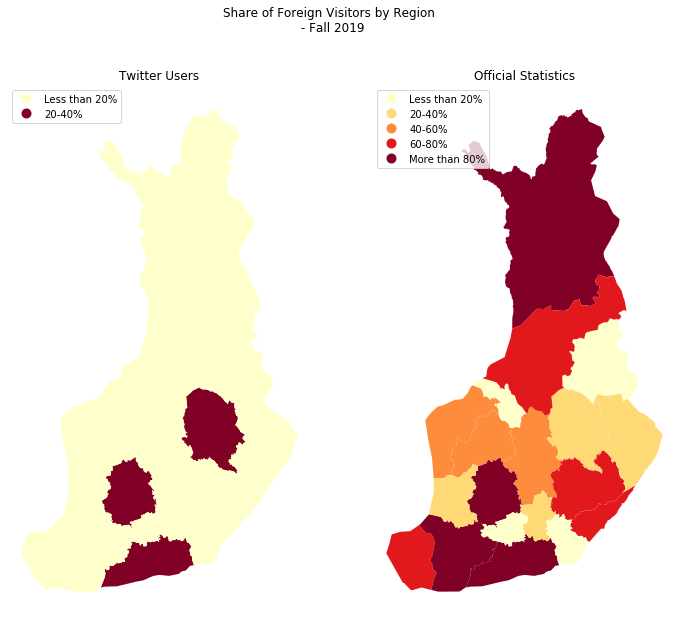

In [36]:
from twitter_visitor_funcitons import foreignersTwitterOfficial
official_foreigners = 'officialStats/foreignv3_s.shp'

foreignersTwitterOfficial(regional_names,official_foreigners,labels, finland_fp)

## Offical Finns vs Foreigners

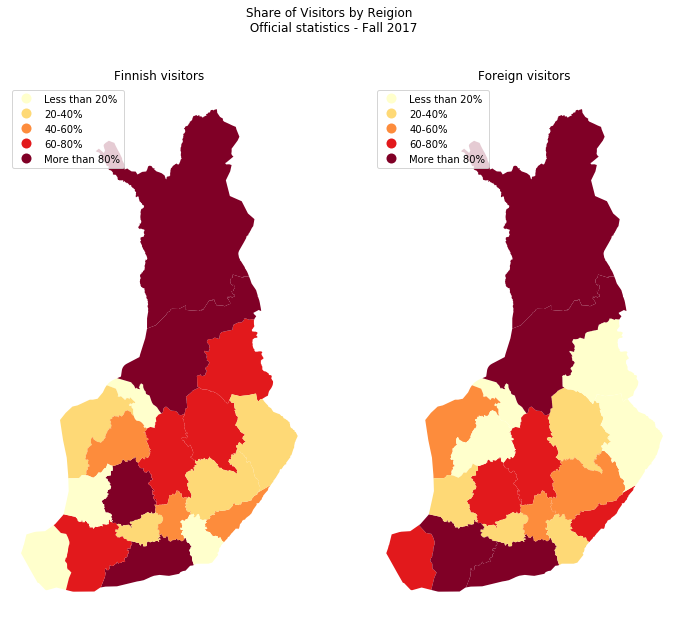

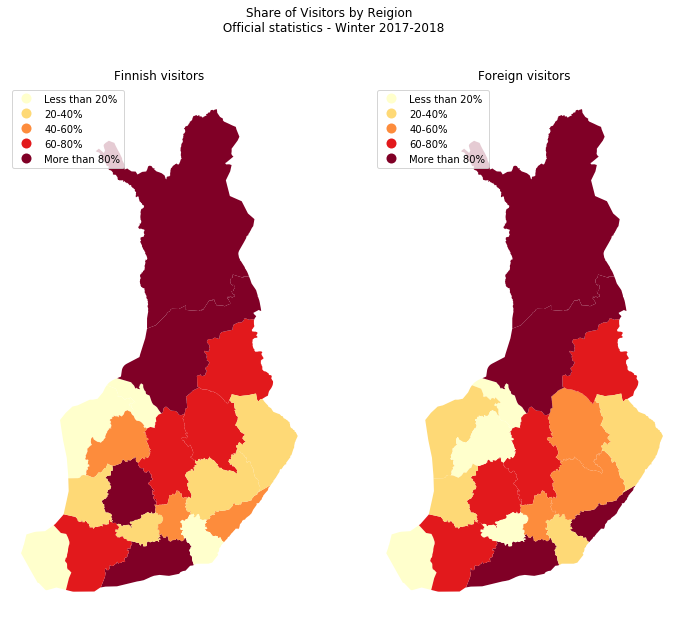

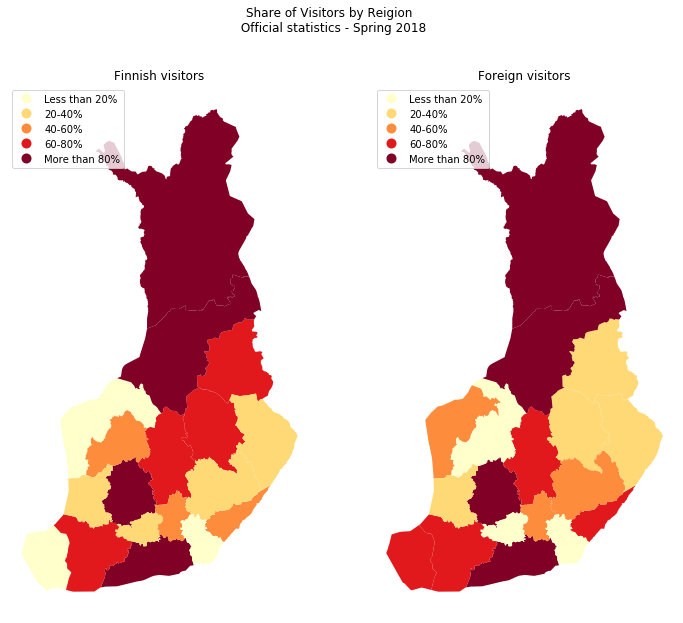

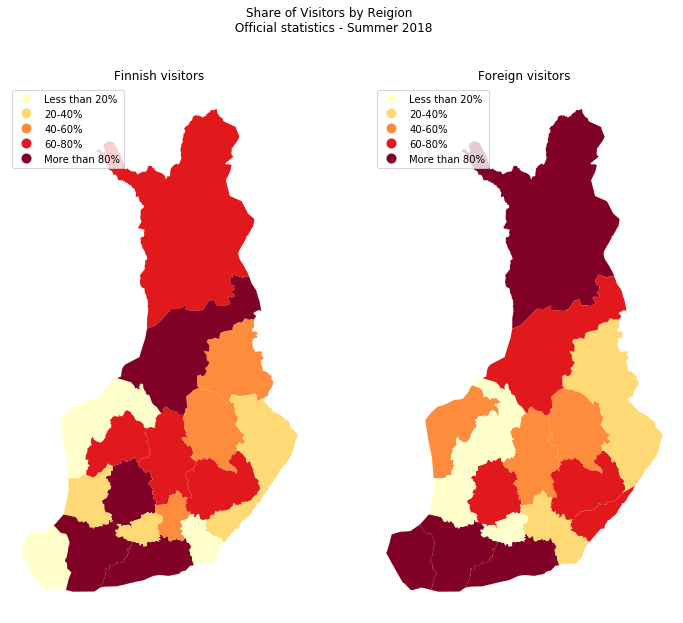

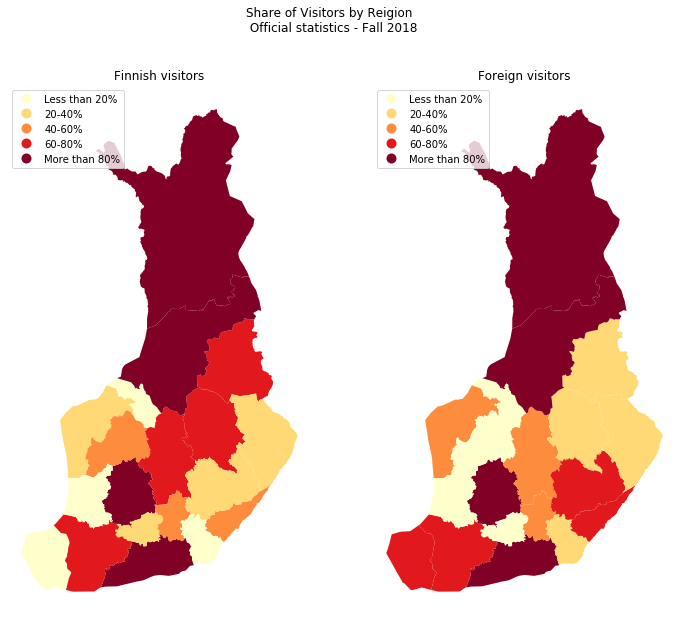

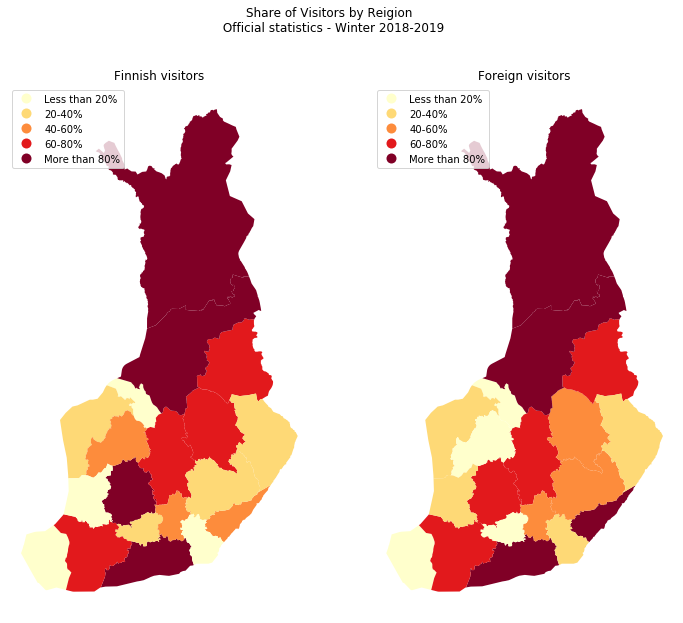

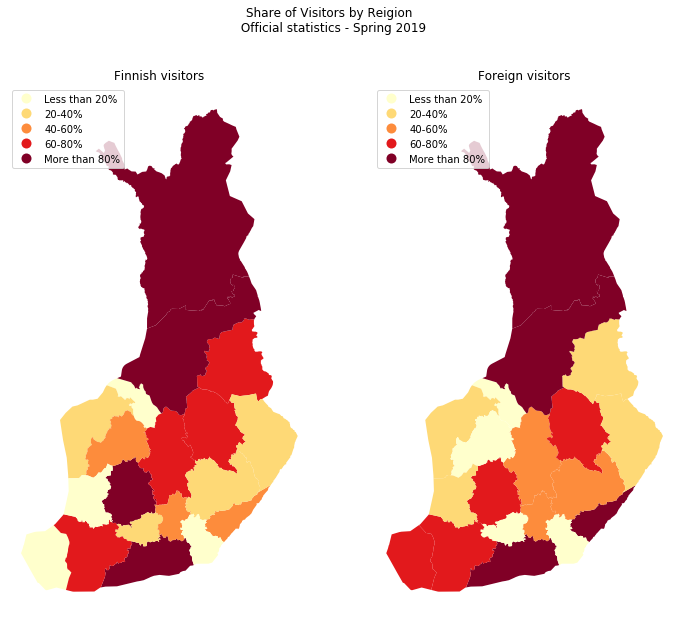

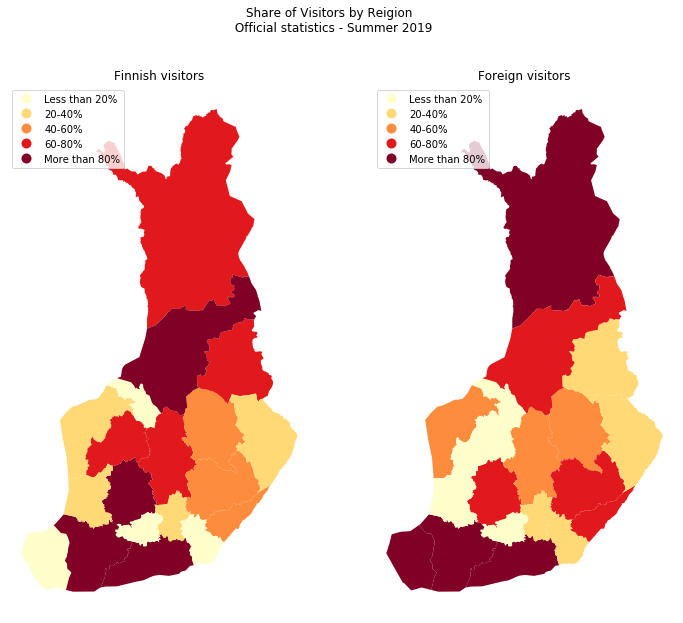

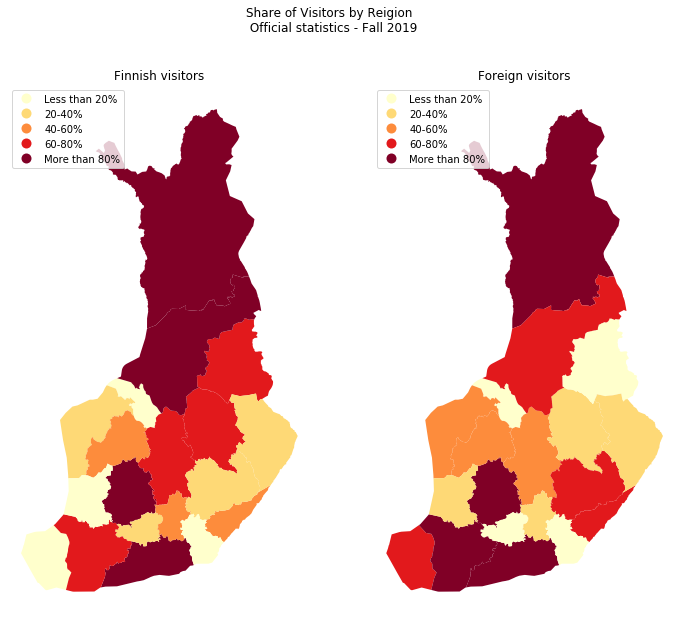

In [37]:
from twitter_visitor_funcitons import officialComparison
officialComparison(official_finns, official_foreigners, labels, finland_fp)

### Bar chart

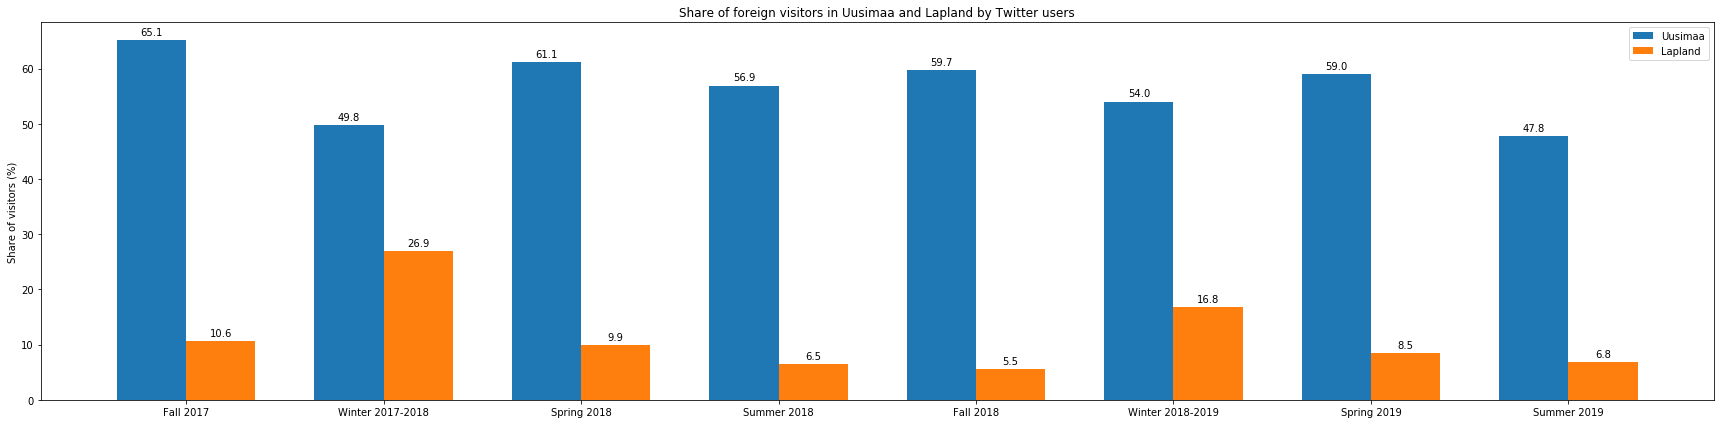

In [38]:
folder = 'regions_seasons/'
regional_names = ['fall2017_regional', 'winter2017_2018_regional','spring2018_regional','summer2018_regional','fall2018_regional','winter2018_2019_regional', 'spring2019_regional', 'summer2019_regional']
labels = ['Fall 2017', 'Winter 2017-2018','Spring 2018','Summer 2018','Fall 2018','Winter 2018-2019', 'Spring 2019', 'Summer 2019']
uusimaaVisitors = []
lappiVisitors = []
for season in regional_names:
    full_path = 'regions_seasons/' + season + '.gpkg'
    gdf = gpd.read_file(full_path)
    total = gdf['foreigners'].sum()
    #print(total)
    uusimaa = gdf.loc[gdf['NAMEFIN']=='Uusimaa']['foreigners'].values
    uusimaaShare = round((uusimaa[0]/total)*100,1)
    lappi = gdf.loc[gdf['NAMEFIN']=='Lappi']['foreigners'].values
    lappiShare = round((lappi[0]/total)*100,1)
    uusimaaVisitors.append(uusimaaShare)
    lappiVisitors.append(lappiShare)

combined = [uusimaaVisitors] + [lappiVisitors]
x = np.arange(len(regional_names))
width = 0.35
fig, ax = plt.subplots(figsize=(24,6))
rects1 = ax.bar(x-width/2, uusimaaVisitors, width, label='Uusimaa')
rects2 = ax.bar(x+width/2, lappiVisitors, width, label='Lapland')
ax.set_ylabel('Share of visitors (%)')
ax.set_title('Share of foreign visitors in Uusimaa and Lapland by Twitter users')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
fig.savefig('ShareOfVisitors.png', dpi=300)